In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
from scipy import fftpack
from scipy.signal import argrelextrema, find_peaks

In [3]:
import sys
#sys.path.append('C:\\Users\\claudio.caccia\\Dropbox\\00_Aero\\10_Tesi\\001_rho\\copy\\python')
sys.path.append('../../../../utils/python')

In [4]:
import read_forces as rf
import mbdyn_reader as mbd_r

In [5]:
N = '10' # '4' o '5'
dirlist = ['./CSM1-'+N+'/','./CSM2-'+N+'/','./CSM3-'+N+'/']

In [6]:

raw_data = {}

for curr_dir in dirlist:
    raw_data[curr_dir] = {}
    os.chdir(curr_dir)
    print("reading folder: {0}".format(curr_dir))
    raw_data[curr_dir]['MBD_tip_disp'] = np.genfromtxt('./precice-Solid-watchpoint-tip.log',skip_header=1)
    
    #str_force = np.genfromtxt('./Solid/resultant.txt',skip_header=1)
    
    #raw_data[curr_dir]['MBD_iter'] = MBD_iter
    # raw_data[curr_dir]['MBD_tip_disp'] = MBD_tip_disp
    #raw_data[curr_dir]['str_force'] = str_force
    
    #name = './Solid/out_mbd'
    
    #d_act = mbd_r.read_data(name+'.act')
    #d_ine = mbd_r.read_data(name+'.ine')
    #d_mov = mbd_r.read_data(name+'.mov')
    #d_frc = mbd_r.read_frc(name+'.frc')
    #d_jnt = mbd_r.read_data(name+'.jnt')
    #raw_data[curr_dir]['d_act'] = d_act

    os.chdir('../')

reading folder: ./CSM1-10/
reading folder: ./CSM2-10/
reading folder: ./CSM3-10/


In [7]:
deltat = 0.001

#tt = np.arange(0,8,deltat)

In [8]:
def find_crossings(sig, offset = 0):
    indices = np.where(( (sig[1:]-offset) >= 0) & ( (sig[:-1]-offset) < 0))
    return indices[0]

In [9]:
def freq_from_crossings(sig, fs=1000):
    """Estimate frequency by counting zero crossings
    
    Pros: Fast, accurate (increasing with data length).  Works well for long low-noise sines, square, triangle, etc.
    
    Cons: Doesn't work if there are multiple zero crossings per cycle, low-frequency baseline shift, noise, etc.
    
    """
    # Find all indices right before a rising-edge zero crossing
    indices = find_crossings(sig)
    
    # Naive (Measures 1000.185 Hz for 1000 Hz, for instance)
    #crossings = indices
    
    # More accurate, using linear interpolation to find intersample 
    # zero-crossings (Measures 1000.000129 Hz for 1000 Hz, for instance)
    crossings = [i - sig[i] / (sig[i+1] - sig[i]) for i in indices]
    
    # Some other interpolation based on neighboring points might be better. Spline, cubic, whatever
    
    return fs / np.average(np.diff(crossings)), indices[0], indices[-1]

In [10]:
def comp_freq(x, f_s=1000, plot_freq=False):
    # f_s Sampling rate, or number of measurements per second
    offset0 = np.mean(x)
    print("offset = {0}".format(offset0))
    
    X = fftpack.fft(x-offset0)
    freqs = fftpack.fftfreq(len(x)) * f_s
    
    if plot_freq:
        fig, ax = plt.subplots()
        ax.stem(freqs, np.abs(X))
        ax.set_xlabel('Frequency in Hertz [Hz]')
        ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
        ax.set_xlim(0, 7.5)
        #ax.set_ylim(-5, 110)

    fd = freqs[np.argmax(np.abs(X))]
    # print("max freqency = {0}".format(fd))
    
    # for local maxima
    #m_max = argrelextrema(x, np.greater)
    
    m_max, _ = find_peaks(x, height=offset0, distance = 50)
    
    # for local minima
    # m_min = argrelextrema(x, np.less)
    
    m_min, _ = find_peaks(-x, height=-offset0, distance = 50)
    
    #print(m_max, x[m_max])
    #print(x[m_min])
    
    #plt.figure(figsize=(16,10))
    #plt.plot(x)
    #plt.plot(m_max,x[m_max],'o')
    
    #print(mmb, x[mmb])
    #print(x[mib])

    top_tip = np.mean(x[m_max])
    bottom_tip = np.mean(x[m_min])
    
    offset = (top_tip + bottom_tip)/2 
    
    Δpos = (top_tip-offset)
    Δneg = (offset-bottom_tip)
    
    peak_freq = 1000./np.mean(np.diff(m_max))
    

    
    
    
    print("oscillation: pos={0} | neg={1} | mean={2}".format(Δpos, Δneg, (Δpos+Δneg)/2 ))
    print("peak frequency: {0} Hz".format(peak_freq))

    return [offset, Δpos, Δneg, (Δpos+Δneg)/2, peak_freq]

In [11]:
# for presentation
font = 14
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

# Plot Displacements

select case to plot:

In [20]:
curr_dir = dirlist[0]

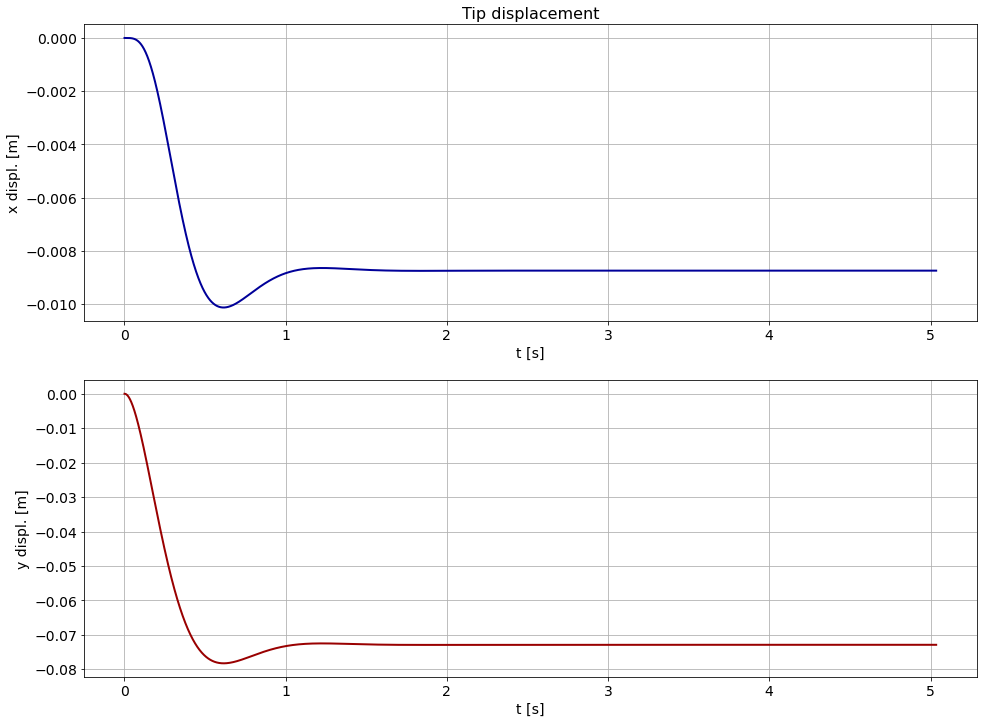

In [21]:
plt.figure(figsize=(16,12))

plt.subplot(2,1,1)
plt.title(r'Tip displacement',fontsize=font+2)
plt.plot(raw_data[curr_dir]['MBD_tip_disp'][:,0],raw_data[curr_dir]['MBD_tip_disp'][:,7],lw=2.,color=[0.0,0.0,0.6],label=r'$x$ tip displacement')
#plt.legend(fontsize=font)
#plt.xlim([0,16])
plt.xlabel("t [s]",fontsize=font)
plt.ylabel("x displ. [m]",fontsize=font)
plt.grid()

plt.subplot(2,1,2)
plt.plot(raw_data[curr_dir]['MBD_tip_disp'][:,0],raw_data[curr_dir]['MBD_tip_disp'][:,8],lw=2.,color=[0.6,0.0,0.0],label=r'$y$ tip displacement')
#plt.legend(fontsize=font)
#plt.xlim([0,16])
plt.xlabel("t [s]",fontsize=font)
plt.ylabel("y displ. [m]",fontsize=font)
plt.grid()



#plt.savefig('disp_'+curr_dir[2:-1]+'.png')

## CSM 1

In [14]:
curr_dir = dirlist[0]
x_tip = raw_data[curr_dir]['MBD_tip_disp'][-1,7]
y_tip = raw_data[curr_dir]['MBD_tip_disp'][-1,8]

print('CSM1: x tip displacement: {0} [mm]'.format(x_tip*1000))
print('CSM1: y tip displacement: {0} [mm]'.format(y_tip*1000))

CSM1: x tip displacement: -8.742549808947999 [mm]
CSM1: y tip displacement: -72.8986793150585 [mm]


## CSM 2

In [15]:
curr_dir = dirlist[1]
x_tip = raw_data[curr_dir]['MBD_tip_disp'][-1,7]
y_tip = raw_data[curr_dir]['MBD_tip_disp'][-1,8]

print('CSM2: x tip displacement: {0} [mm]'.format(x_tip*1000))
print('CSM2: y tip displacement: {0} [mm]'.format(y_tip*1000))

CSM2: x tip displacement: -0.5759473770439 [mm]
CSM2: y tip displacement: -18.8305999177065 [mm]


## CSM 3

In [16]:
curr_dir = dirlist[2]

cross_index = find_crossings(raw_data[curr_dir]['MBD_tip_disp'][:,8],-0.065)
print(cross_index)
print(raw_data[curr_dir]['MBD_tip_disp'][cross_index,0])

i_start = cross_index[2]
i_stop = cross_index[-1]

print(raw_data[curr_dir]['MBD_tip_disp'][cross_index[2],0])
print(raw_data[curr_dir]['MBD_tip_disp'][cross_index[-1],0])

[ 717 1659 2602 3546 4489]
[0.718 1.66  2.603 3.547 4.49 ]
2.6029999999998243
4.489999999999834


In [17]:
print('X displacement')
comp_freq(raw_data[curr_dir]['MBD_tip_disp'][i_start:i_stop,7])
print('Y displacement')
comp_freq(raw_data[curr_dir]['MBD_tip_disp'][i_start:i_stop,8])

X displacement
offset = -0.012865626278768257
oscillation: pos=0.01755667211023052 | neg=0.017556672110230525 | mean=0.01755667211023052
peak frequency: 1.0570824524312896 Hz
Y displacement
offset = -0.0708169666601447
oscillation: pos=0.07120381676763632 | neg=0.07120381676763632 | mean=0.07120381676763632
peak frequency: 1.0615711252653928 Hz


[-0.07042304902337912,
 0.07120381676763632,
 0.07120381676763632,
 0.07120381676763632,
 1.0615711252653928]

In [18]:
x = raw_data[curr_dir]['MBD_tip_disp'][i_start:i_stop,8]

cross_freq = freq_from_crossings(x,1000)
print(cross_freq)
    
offset2 = np.mean(x)
Δpos2 = (np.max(x)-offset2)
Δneg2 = (offset2-np.min(x))

print("oscillation: pos={0} | neg={1} | mean={2}".format(Δpos2, Δneg2, (Δpos2+Δneg2)/2 ))

#print("offset: {0}".format(offset2))
print("crossing frequency: {0} Hz".format(cross_freq[0]))

(1.0640106234496551, 192, 1132)
oscillation: pos=0.07176846470852209 | neg=0.07090578170392839 | mean=0.07133712320622523
crossing frequency: 1.0640106234496551 Hz


In [19]:
x = raw_data[curr_dir]['MBD_tip_disp'][i_start:i_stop,7]

cross_freq = freq_from_crossings(x,1000)
print(cross_freq)
    
offset2 = np.mean(x)
Δpos2 = (np.max(x)-offset2)
Δneg2 = (offset2-np.min(x))

print("oscillation: pos={0} | neg={1} | mean={2}".format(Δpos2, Δneg2, (Δpos2+Δneg2)/2 ))

#print("offset: {0}".format(offset2))
print("crossing frequency: {0} Hz".format(cross_freq[0]))

(1.0522895048643734, 229, 1179)
oscillation: pos=0.012866530037006057 | neg=0.022326677927343844 | mean=0.01759660398217495
crossing frequency: 1.0522895048643734 Hz
